# Ensemble
`06_ensemble.ipynb`

- 정형 데이터(Structured Data) 기준으로는 가장 뛰어난 성과를 내는 알고리즘 -> 앙상블학습
- 대부분의 앙상블학습 -> 트리기반

## Random Forest 
- 결정트리를 랜덤하게 만들어 트리의 숲을 만듦
- 각 결정트리의 예측을 종합해 최종 예측을 만듦
- 과대적합(overfitting)에 안전하다. 

### 데이터 분할 
- 데아터가 1000개면, 각 트리마다 1000개 데이터를 복원추출함. 이때 중복을 허용 (우연히 같은 데이터만 1000개 가능)
- 노드를 분할시, 분류기 / 회귀의 특성 선택방식이 다름(분류: 개수를 루트함, 회귀: 특성을 다 씀)
- 기본값 100개의 트리를 만들어서
    - 분류 : 다수결 투표 
    - 회귀 : 100개의 평균 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('./wine.csv')
X = wine[['alcohol', 'sugar', 'pH']]
y=  wine['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs =-1, random_state=42)
#교차검증(5fold)
scores = cross_validate(rf, X_train, y_train, return_train_score=True, n_jobs=-1)


#결정트리가 max_depth 지정이 없으면 Overfitting됨 
#훈련셋 (일부)                                      검증셋(훈련셋의 일부) 

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) ## 모든나무에 과적합이 있기 때문에 숲에도 과적합이 있는 상태 

#진짜 학습시키기
rf.fit(X_train, y_train)
#트리 (100개)들의 특성별 중요도 수치화 

'''
노드마다 랜덤하게 특성들을 뽑아서 사용 - 다양한 특성들이 훈련에서 기준으로 쓰임
-> 특정 특성에 과도하게 집중( overfitting) 방지 -> 다양한 특성이 훈련에 쓰일 기회를 받음-> 과적합을 줄이고 일반화 성능 높임 
'''
print(rf.feature_importances_)


In [ ]:
# OOB -> 쓰지 않은 샘플 존재 -> 남은(쓰지 않은) 샘플들을 모아서 만든 샘플 (훈련에 참여 안한 샘플 )
# OOB 샘플로 점수 -> 마치 검증샘플 같은 역할 

rf= RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.oob_score_)

# 코드정리 
- 데이터준비: 와인 데이터셋을 불러와서 특징과 타겟으로 나눈 후 **훈련 세트와 테스트 세트로 분할** 한다.
- 교차검증: 교차검증으로 랜덤포레스트모델을 훈련시킨다, 출력결과 훈련점수가 검증 점수보다 훨씬 높아서 **과적합** 됨을 알 수 있다. 
- 특성 중요도 : 모델을 훈련시킨 후, 각**특성의 중요도를 출력한**다(rf.feature_importances_)
- OOB 점수: oob_score =True 를 설정힌 세로운 RandomForestClassifier를 생성한다. **oob 점수는 각 트리의 부트스트랩 샘플에 포함되지 않은 샘플을
사용하여 계산되는 유효성 검사 점수**이다. 이는 별도의 검증 세트 없이도 모델의 성능을 추정할 수 있게 해준다. 출력결과 OOB 점수는 모델이 보지 못한 데이터에 대한 일반화 성능을 
잘 근사한다. 

In [ ]:

# 랜덤 포레스트의 하이퍼 파라미터 튜닝

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


params = {
    # Decision Tree 의 HP
    'max_depth': randint(3, 50), # 트리의 최대 깊이: 개별 결정 트리 복잡성 제어 
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    # Random Forest 의 HP
    'max_features': ['sqrt', 'log2', None],  # 노드별 분할시 고려할 특성 수 (None->모든 특성 고려)
    'n_estimators': randint(50, 300)  # 트리의 개수 (랜덤포레스트에 포함될 결정 트리의 수dmlal) 
}

rs = RandomizedSearchCV(
    rf,
    params,
    n_iter=100,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

# 용어 정리 
- randint: 정수형 분포 생성, 트리계수(n_estimators) 나 최대 깊이(max_depth)와 같은 이산형 하이퍼파라미터에 유용, low 와 high 매개변수로 랜덤 정수의 범위 정의 
- uniform: 연속적인 균등 분포 생성 (특정 범위 내의 어떤 실수 값도 가질수 있는 하이퍼 파라미터에 적합)
- param_distribution: 튜닝할 하이퍼파하미터의 범위를 지정하는 딕셔너리(키는 하이퍼 파라미터 이름이고, 값은 RandomizedSearxhCV가 샘플링할 분포이다. 
- RandomizedSearchCV
- n_iter: 샘플링할 파라미터 조합의 수를 지정하며, 이 값이 클수록 더 철저하게 탐색하지면 런타임이 길어진다. 
- 훈련 및 평가:RandomizedSearchCV  객체를 훈련데이터에 fit 하면 각 샘플링된 조합에 대해 교차 검증을 자동으로 수행한다. 이후 최적의 파라미터와 점수를 출력하고, 테스트 세트에서 최적의 모델을 평가하여 일반화 성능을 확인한다. 


In [21]:
print('최적 파라미터', rs.best_params_)
print('최고 교차검증 점수', rs.best_score_)
print('테스트 스코어', rs.score(X_test, y_test))
# 최적 모델 인스턴스
best_rf = rs.best_estimator_
print('특성 중요도', best_rf.feature_importances_)

최적 파라미터 {'max_depth': 14, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 217}
최고 교차검증 점수 0.8880125120307989
테스트 스코어 0.88
특성 중요도 [0.22251602 0.53169184 0.24579215]


# 결과해석
1. 217개의 결정트리가 모여 최종 예측을 수행한다. 앙상블 효과를 통해 모델의 안정성을 높이고 분산을 줄이는데 기여
2. 개별 트리의 최대 깊이가 14로 제한됨. 나무가 너무 깊어져 훈련데이터에 과적합 되는 것을 방지 
3. max_features None: 각 노드를 분할할 때 모든특성(알콜, 당도, 산성도)을 고려함.랜덤 포레스트의 기본 동작인 특성 랜덤 샘플링을 적용하지 않음.
4. 노드를 분할하기 위해 최소 2개의 샘플이 필요하다는 의미. 기본값과 동일하며 노드를 계속 분할하려는 경향
5. 리프노드가 되기 위해 최소 1개의 샘플이 필요하다는 의미 , 기본값과 동일하며, 가장 깊은 수준까지 트리 성장 가능하다. 

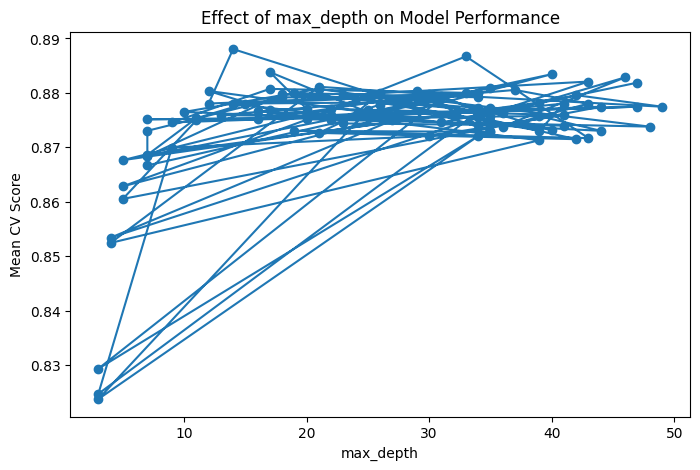

In [22]:
import matplotlib.pyplot as plt

results = pd.DataFrame(rs.cv_results_)

# max_depth vs mean_test_score
plt.figure(figsize=(8, 5))
plt.plot(results['param_max_depth'], results['mean_test_score'], marker='o')
plt.xlabel("max_depth")
plt.ylabel("Mean CV Score")
plt.title("Effect of max_depth on Model Performance")
plt.show()

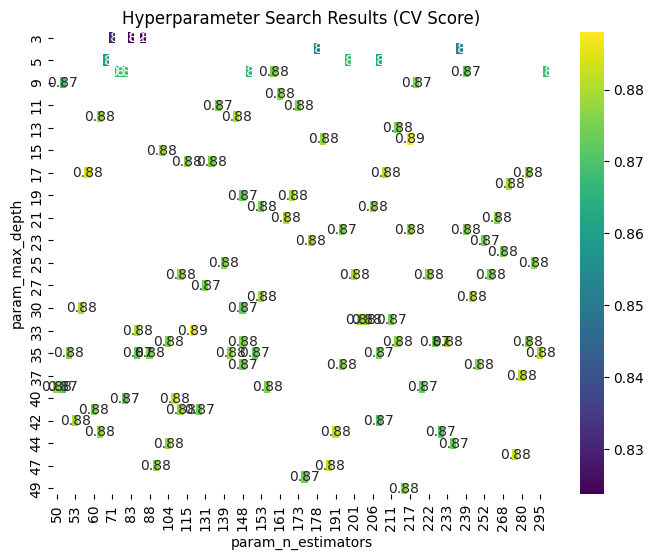

In [23]:
import seaborn as sns

pivot_table = results.pivot_table(values='mean_test_score',
                                  index='param_max_depth',
                                  columns='param_n_estimators')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title("Hyperparameter Search Results (CV Score)")
plt.show()

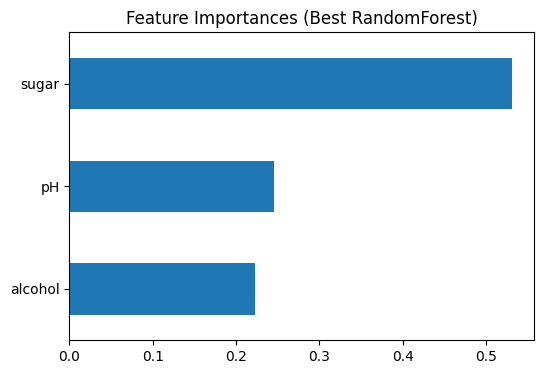

In [24]:
best_rf = rs.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=X.columns)

plt.figure(figsize=(6,4))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances (Best RandomForest)")
plt.show()

## 그래프 결과
- 모델이 와인의 종류를 분류할 때 설탕함량이 가장 중요한 요인이라고 판단함. 


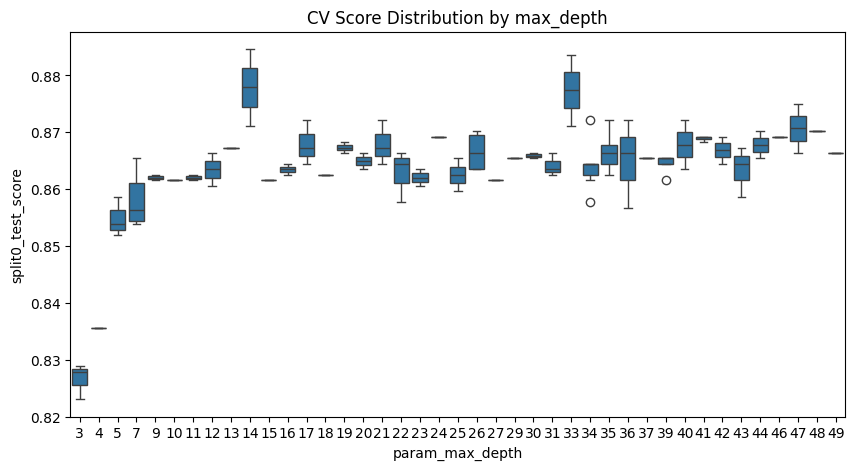

In [25]:
# 교차검증 결과 분포
plt.figure(figsize=(10,5))
sns.boxplot(x='param_max_depth', y='split0_test_score', data=results)
plt.title("CV Score Distribution by max_depth")
plt.show()

## Extra Tree 
- 랜덤포레스트와 매우 유사 
- 부트스트랩 샘플(복원추출)을 사용하지 않음 
- 전체 훈련세트 그대로 사용함. 특성도 무작위 선택 
- 노드 분할할 때, 최적(불순도/ 정보이득)을 찾는 것이 아니라 무작위로 분할 
- 성능이 낮아질 수 있지만,  많은 트리를 앙상블 해서 과대적합을 방지 
- 데이터 노이즈가 많은 경우 장점 (패턴과 상관없는 불필요/ 잘못된)

### 결정트리를 기반으로 하는 앙상블(ensemble모델) 모델 
- 랜덤포레스트: 노드를 분할할 때 최적의 특성과 최적의 분할 기준을 찾음. 
- 엑스트라 트리: 노드를 분할할 때 무작위로 선택된 특성과 무작위로 선택된 분할 기준사용 
 * 엑스트라 트리는 랜덤포레스트 보다 더 많은 무작위성을 추가해서 계산속도를 높이고 과적합을 더 효과적으로 방지한다. 
랜덤 포레스트는 각 트리가 최적의 경로를 찾으므로 개별 트리가 더 정확하지만. 엑스트라 트리는 무작위성을 통해 모델의 분산을 크게 줄여 더 강력한 일반화 성능을 얻는다.




In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state= 42)
scores = cross_validate(et, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

et.fit(X_train, y_train)

print(et.score(X_test, y_test), et.feature_importances_)

## 그래디언트 부스팅 
- 부스팅: 약한 모델(결정트리가 얕다)을 여러 개 차례대로 학습. 
- 앞에 모델에서 틀린 부분을 뒤의 모델이 보완해주는 방식 
- 그래디언트: 오차를 줄이기 위해 경사하강법 아이디어를 적용 
- 비선형, 복잡한 데이터에서 예측이 뛰어남
- 과적합 방지 가능한 여러 규제들이 있음
- 별도 전용 라이브러리(XGBoost, LightGBM, CatBoost) -> 대회에서 1등 먹은 적이 많음 

### 장점 
* 비선형, 복잡한 데이터에서 예측이 뛰어남
* 과적합 방지 가능한 여러 규제들이 있음 
* 별도 전용 라이브러리 (Hist 기반: XGBoost, LightGBM, CatBoost)
### 단점
- 학습속도 느림  
- 경사 하강법(Gradient Descent)은 본질적으로 순차적(sequential) 알고리즘이기 때문에 멀티코어(멀티 스레드)를 이용한 병렬화가 어렵습니다.
- 하이퍼파라미터가 많아서 튜닝이 필요 
- 데이터 노이즈에 민감한 편 

### 동작 

1. 약한 첫번째 결정트리 학습 -> 기본 예측값 생성 
2. 오차/잔차(residual) 계산 (답 - 예측)
3. 이 잔차를 예측하도록 또 다른 작은 트리를 학습 -> 예측값 업데이트 
4. 반복-> 오차가 줄어듦



In [ ]:
#경사 부스팅(Gradient Boosting) 모델을 사용해 와인 데이터셋을 분류하고 성능평가 
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))
"""  
모델이 훈련데이터에 약 88.8%의 정확도를, 검증 데이터에 대해 약 87.2%의 정확도를 보임, 훈련과 검증 점수의 차이가 크지않아서 
도델이 과적합되지 않음 
"""
# 학습 -> 테스트 셋 점수
gb.fit(X_train, y_train)
print(gb.score(X_test, y_test))

# RF(랜뎀포레스트) : 0.9973541965122431 0.8905151032797809
# ET(엑스트라 트리) : 0.9974503966084433 0.8887848893166506
# GB(경사부스팅s) : 0.8881086892152563 0.8720430147331015

0.8881086892152563 0.8720430147331015
0.8669230769230769


## 히스토그램 기반 그래디언트 부스팅 

- 입력 특성들을 256개 구간으로 나눔 
- 노드 분할 할때 , 구간 경계값(256개)을 쓰기에 최적 분할을 가장 빠르게 찾을 수 있다. 

Hist Gradient Boosting 은 결측치를 자동으로 채워주는 기능이 있다. 



## 1. 직접 결측치 채우기 (Imputation)
방법: 평균/중앙값 대체, KNN imputation, MICE 등

- ✅ 장점
모델에 독립적: 어떤 모델이든(트리, 선형, 신경망) 학습할 수 있게 됨
도메인 지식 반영 가능: 예를 들어 나이가 결측이면 "20대 평균값"으로 채우는 식으로 의미 있게 대체 가능
노이즈 제어 가능: 결측치가 너무 많을 때 모델이 이상하게 학습하지 않도록 사전에 통제 가능

- ⚠️ 단점
잘못된 방법으로 채우면 편향이 생길 수 있음 (예: 평균 대체 → 분산 축소, 패턴 왜곡)
고차원 데이터에서 계산량이 크거나 불안정할 수 있음 (특히 MICE, KNN)




----------





## 2. HistGradientBoosting에 맡기기 (자동 결측 처리)

- ✅ 장점
추가 전처리 불필요: NaN 그대로 넣으면 학습 가능 → 파이프라인 단순화
모델이 결측 그 자체를 패턴으로 활용 가능 (예: “나이 없음” 자체가 중요한 특징일 때 유용)
빠르고 효율적 (히스토그램 기반 트리라 속도도 빠름)

- ⚠️ 단점
다른 모델에 적용 불가 (결측치 처리 기능이 없는 모델과 비교 불가)
결측치가 너무 많으면, 모델이 “NaN 브랜치”에 데이터를 몰아넣어서 과적합 위험 있음
도메인 지식을 반영하기 어려움 (모델이 무작정 NaN을 또 하나의 값으로 취급)

In [28]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# 학습 -> 테스트 셋 점수
hgb.fit(X_train, y_train)
print(hgb.score(X_test, y_test))
## 교차 검증 결과는 일반화 성능이 낮고, 훈련데이터의 패턴을 잘학습해 과적합되어 있음. 
## 테스트 세트 점수: 교차 검증 점수(0.88)와 (0.872)가 매우 유사 , 모델이 훈련에 사용되지 않은 
## 최종 데이터에 대해 얻은 최종 정확도는 모델이 안정적이고 일반화 성능이 양호함을 보여준다 

0.9321723946453317 0.8801241948619236
0.8723076923076923


In [29]:
%pip install xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)

scores = cross_validate(xgb, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

xgb.fit(X_train, y_train)
print(xgb.score(X_test, y_test))


In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)

scores = cross_validate(lgb, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

lgb.fit(X_train, y_train)
print(lgb.score(X_test, y_test))